# Obtaining an equilibrated initial trajectory

This is the first file to run in the alanine dipeptide TPS example. This teaches you how to:

* set up an engine using OpenMM
* set up states using MDTraj-based collective variables
* obtain a initial trajectory using high temperature MD
* equilibrate by using shooting moves until the first decorrelated trajectory

We assume at this point that you are familiar with the basic concepts of OPS. If you find this file confusing, we recommend working through the toy model examples.

In [1]:
from __future__ import print_function
%matplotlib inline
import matplotlib.pyplot as plt
import openpathsampling as paths

import openpathsampling.engines.openmm as omm
from simtk.openmm import app
import simtk.openmm as mm
import simtk.unit as unit
from openmmtools.integrators import VVVRIntegrator

import mdtraj as md

import numpy as np

import os
initial_pdb = os.path.join("..", "resources", "AD_initial_frame.pdb")

## Setting up high-temperature engine

Now we set things up for the OpenMM simulation. We will need a `openmm.System` object and an `openmm.Integrator` object.

To learn more about OpenMM, read the [OpenMM documentation](http://docs.openmm.org). The code we use here is based on output from the convenient web-based [OpenMM builder](http://builder.openmm.org).

In [2]:
# this cell is all OpenMM specific
forcefield = app.ForceField('amber96.xml', 'tip3p.xml')
pdb = app.PDBFile(initial_pdb)
system = forcefield.createSystem(
    pdb.topology, 
    nonbondedMethod=app.PME, 
    nonbondedCutoff=1.0*unit.nanometers,
    constraints=app.HBonds, 
    rigidWater=True,
    ewaldErrorTolerance=0.0005
)
hi_T_integrator = VVVRIntegrator(
    500*unit.kelvin, 
    1.0/unit.picoseconds, 
    2.0*unit.femtoseconds)
hi_T_integrator.setConstraintTolerance(0.00001)

The storage file will need a template snapshot. In addition, the OPS OpenMM-based `Engine` has a few properties and options that are set by these dictionaries.

In [3]:
template = omm.snapshot_from_pdb(initial_pdb)
openmm_properties = {'OpenCLPrecision': 'mixed'}
engine_options = {
    'n_steps_per_frame': 10,
    'n_frames_max': 20000
}

In [4]:
hi_T_engine = omm.Engine(
    template.topology, 
    system, 
    hi_T_integrator, 
    openmm_properties=openmm_properties,
    options=engine_options
)
hi_T_engine.name = '500K'

In [5]:
hi_T_engine.current_snapshot = template
hi_T_engine.minimize()

## Defining states

First we define the CVs using the `md.compute_dihedrals` function. Then we define our states using `PeriodicCVDefinedVolume` (since our CVs are periodic.)

In [6]:
# define the CVs
psi = paths.MDTrajFunctionCV(
    "psi", md.compute_dihedrals,
    topology=template.topology, indices=[[6,8,14,16]]
).enable_diskcache()
phi = paths.MDTrajFunctionCV(
    "phi", md.compute_dihedrals,
    topology=template.topology, indices=[[4,6,8,14]]
).enable_diskcache()

In [7]:
# define the states
deg = 180.0/np.pi
C_7eq = (
    paths.PeriodicCVDefinedVolume(phi, lambda_min=-180/deg, lambda_max=0/deg, 
                                  period_min=-np.pi, period_max=np.pi) &
    paths.PeriodicCVDefinedVolume(psi, lambda_min=100/deg, lambda_max=200/deg,
                                  period_min=-np.pi, period_max=np.pi)
).named("C_7eq")
# similarly, without bothering with the labels:
alpha_R = (
    paths.PeriodicCVDefinedVolume(phi, -180/deg, 0/deg, -np.pi, np.pi) &
    paths.PeriodicCVDefinedVolume(psi, -100/deg, 0/deg, -np.pi, np.pi)
).named("alpha_R")

## Getting a first trajectory

The idea here is a little subtle, but it makes nice use of our generalized path ensemble idea.

We want a path which contains at least one frame in each state. The question is, what ensemble can we use to create such a trajectory?

The first obvious thought would be `goal_ensemble = PartInXEnsemble(stateA) & PartInXEnsemble(stateB)` (which can, of course, be further generalized to more states). However, while that *is* the ensemble we want to eventually satisfy, we can't use its `can_append` to create it, because its `can_append` always returns `True`: the trajectory will go on forever!

But we can use a trick: since what we want is the first trajectory that satisfies `goal_ensemble`, we know that every shorter trajectory will not satisfy it. This means that the shorter trajectories must satisfy the *complement* of `goal_ensemble`, and the trajectory we want will be the first trajectory that does *not* satisfy the complement!

So the trick we'll use is to build the trajectory by using the fact that the shorter trajectories are in the complement of `goal_ensemble`, which is given by `complement = AllOutXEnsemble(stateA) | AllOutXEnsemble(stateB)`. The `generate` function will stop when that is no longer true, giving us the trajectory we want. This can be directly generalized to more states.

Note that here we're not even using the `can_append` function. That happens to be the same as the ensemble itself for this particular ensemble, but conceptually, we're actually using the test of whether a trajectory is in the ensemble at all.

```python
init_traj_ensemble = paths.AllOutXEnsemble(C_7eq) | paths.AllOutXEnsemble(alpha_R)
trajectory = hi_T_engine.generate(hi_T_engine.current_snapshot, [init_traj_ensemble])
````

In [8]:
visit_all = paths.VisitAllStatesEnsemble([C_7eq, alpha_R])
trajectory = hi_T_engine.generate(hi_T_engine.current_snapshot, [visit_all.can_append])

Ran 2143 frames. Found states [alpha_R,C_7eq]. Looking for [].


## Plotting the trajectory

In [9]:
# create a network so we can use its ensemble to obtain an initial trajectory
# use all-to-all because initial traj can be A->B or B->A; will be reversed
tmp_network = paths.TPSNetwork.from_states_all_to_all([C_7eq, alpha_R])

In [10]:
# take the subtrajectory matching the ensemble (only one ensemble, only one subtraj)
subtrajectories = []
for ens in tmp_network.analysis_ensembles:
    subtrajectories += ens.split(trajectory)
print(subtrajectories)

[Trajectory[33]]


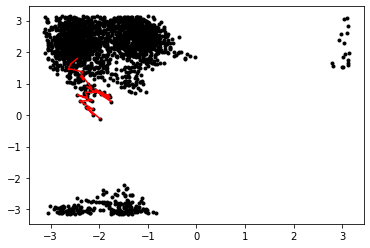

In [11]:
plt.plot(phi(trajectory), psi(trajectory), 'k.')
plt.plot(phi(subtrajectories[0]), psi(subtrajectories[0]), 'r')

## Setting up the normal temperature engine

We'll create another engine that uses a 300K integrator, and equilibrate to a 300K path from the 500K path.

In [12]:
integrator = VVVRIntegrator(
    300*unit.kelvin, 
    1.0/unit.picoseconds, 
    2.0*unit.femtoseconds
)
integrator.setConstraintTolerance(0.00001)
engine = omm.Engine(
    template.topology, 
    system, 
    integrator, 
    openmm_properties=openmm_properties,
    options=engine_options
).named('300K')

## Using TPS to equilibrate

This is, again, a simple path sampling setup. We use the same `TPSNetwork` we'll use later, and only shooting moves. One the initial conditions are correctly set up, we run one step at a time until the initial trajectory is decorrelated.

This setup of a path sampler always consists of defining a `network` and a `move_scheme`. See toy model notebooks for further discussion.

In [13]:
network = paths.TPSNetwork(initial_states=C_7eq,
                           final_states=alpha_R).named('tps_network')
scheme = paths.OneWayShootingMoveScheme(network, 
                                        selector=paths.UniformSelector(),
                                        engine=engine).named('equil_scheme')

The move scheme's `initial_conditions_from_trajectories` method will take whatever input you give it and try to generate valid initial conditions. This includes looking for subtrajectories that satisfy the ensembles you're sampling, as well as reversing the trajectory. If it succeeds, you'll see the message "No missing ensembles. No extra ensembles." It's also a good practice to use `scheme.assert_initial_conditions` to ensure that your initial conditions are valid. This will halt a script if the initial conditions are not valid.

In [14]:
# make subtrajectories into initial conditions (trajectories become a sampleset)
initial_conditions = scheme.initial_conditions_from_trajectories(subtrajectories)

No missing ensembles.
No extra ensembles.


In [15]:
# check that initial conditions are valid and complete (raise AssertionError otherwise)
scheme.assert_initial_conditions(initial_conditions)

We can create a `StepVisualizer2D`, which plays the simulation as it is running. It requires CVs for the $x$ direction and the $y$ direction, as well as bounds of the plot. You can set the `background` attribute to an existing matplotlib `Figure`, and the simulation will plot on top of that. See the toy model MSTIS example for an example of that.

This isn't necessary, and isn't even a useful for long simulations (which typically won't be in an interactive notebook), but it can be fun!

In [16]:
visualizer = paths.StepVisualizer2D(network, phi, psi, xlim=[-3.14, 3.14], 
                                    ylim=[-3.14, 3.14])

In [17]:
sampler = paths.PathSampling(storage=paths.Storage("ad_tps_equil.nc", "w", template),
                             move_scheme=scheme,
                             sample_set=initial_conditions)
sampler.live_visualizer = visualizer

In [18]:
# initially, these trajectories are correlated (actually, identical)
# once decorrelated, we have a (somewhat) reasonable 300K trajectory
initial_conditions[0].trajectory.is_correlated(sampler.sample_set[0].trajectory)

True

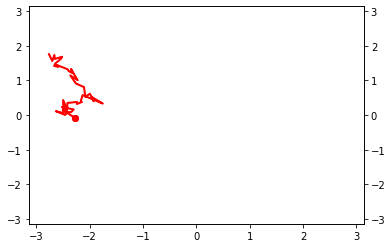

Step 6: All trajectories decorrelated!


In [19]:
sampler.run_until_decorrelated()

In [20]:
# now we have decorrelated: no frames are in common
initial_conditions[0].trajectory.is_correlated(sampler.sample_set[0].trajectory)

False

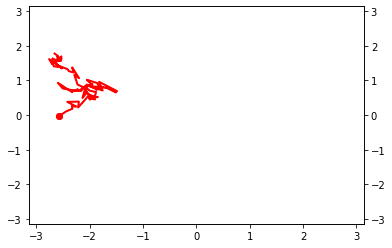

DONE! Completed 15 Monte Carlo cycles.


In [21]:
# run an extra 10 to decorrelate a little futher
sampler.run(10)

In [22]:
sampler.storage.close()

From here, you can either extend this to a longer trajectory for the fixed length TPS in the `AD_tps_1b_trajectory.ipynb` notebook, or go straight to flexible length TPS in the `AD_tps_2a_run_flex.ipynb` notebook.